In [2]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np
import os
import itertools
import sys
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.metrics import confusion_matrix
from copy import copy

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Activation, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Lambda, BatchNormalization, Reshape, Permute
from tensorflow.keras.layers import Concatenate, concatenate, Add, add, Multiply, multiply

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

from tensorflow.keras import backend as K

NUM_OF_GENRES = 10
BATCH_SIZE = 8

In [3]:
# data generator
class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=BATCH_SIZE, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            pass
            #signals = self.__augment(signals)
            
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)
            
            # Perform horizontal flip
            #if np.random.rand() < hor_flip:
                #signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=3)
                cols = np.random.randint(signal.shape[0], size=4)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

In [4]:
# confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# majority vote
def majority_vote(scores):
    values, counts = np.unique(scores,return_counts=True)
    ind = np.argmax(counts)
    return values[ind]


In [5]:
# load data
print('============================================================================')
print('Loading dataset...')
print('============================================================================')
X_train = np.load('/home/jaehwlee/Genre_classification/GNN/BBNN_mel_data/X_train.npy')
X_valid = np.load('/home/jaehwlee/Genre_classification/GNN/BBNN_mel_data/X_valid.npy')
X_test = np.load('/home/jaehwlee/Genre_classification/GNN/BBNN_mel_data/X_test.npy')
y_train = np.load('/home/jaehwlee/Genre_classification/GNN/BBNN_mel_data/y_train.npy')
y_valid = np.load('/home/jaehwlee/Genre_classification/GNN/BBNN_mel_data/y_valid.npy')
y_test = np.load('/home/jaehwlee/Genre_classification/GNN/BBNN_mel_data/y_test.npy')

# X_train = np.load('/home/jaehwlee/SE-ResNeXt/mel_data/0519X_train.npy')
# X_test =np.load('/home/jaehwlee/SE-ResNeXt/mel_data/0519X_test.npy')
# y_train = np.load('/home/jaehwlee/SE-ResNeXt/mel_data/0519y_train.npy')
# y_test = np.load('/home/jaehwlee/SE-ResNeXt/mel_data/0519y_test.npy')

song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

print('============================================================================')
print('complete!')
print('============================================================================')

Loading dataset...
(810, 646, 128, 1)
(90, 646, 128, 1)
(100, 646, 128, 1)
(810, 10)
(90, 10)
(100, 10)
complete!


In [39]:
# callback function
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

mc = ModelCheckpoint('0707_mel.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

rl = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=3, verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-5)
callback_list = [mc,rl]

In [6]:
def BBNN():
    inp = Input(shape=(646,128,1))
    x = Conv2D(32, (3,3), strides=(1,1),padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(4,1), strides=None)(x)

    #inception A
    batch_a = BatchNormalization()(x)
    batch_a = Activation('relu')(batch_a)
    conv1x1a = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_a)

    batch_b = BatchNormalization()(x)
    batch_b = Activation('relu')(batch_b)
    conv1x1b = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_b)
    batch_b2 = BatchNormalization()(conv1x1b)
    batch_b2 = Activation('relu')(batch_b2)
    conv3x3b = Conv2D(32, (3,3), strides=(1,1),padding='same')(batch_b2)

    batch_c = BatchNormalization()(x)
    batch_c = Activation('relu')(batch_c)
    conv1x1c = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_c)
    batch_c2 = BatchNormalization()(conv1x1c)
    batch_c2 = Activation('relu')(batch_c2)
    conv5x5c = Conv2D(32, (5,5), strides=(1,1),padding='same')(batch_c2)

    maxpoold = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(x)
    batch_d = BatchNormalization()(maxpoold)
    batch_d = Activation('relu')(batch_d)
    conv1x1d = Conv2D(32, (1,1), strides=(1,1), padding='same')(batch_d)

    mixed0 = concatenate([x, conv1x1a, conv3x3b, conv5x5c, conv1x1d], axis=3, name='mixed0')
    

    #inceptionB
    batch_a = BatchNormalization()(mixed0)
    batch_a = Activation('relu')(batch_a)
    conv1x1a = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_a)

    batch_b = BatchNormalization()(mixed0)
    batch_b = Activation('relu')(batch_b)
    conv1x1b = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_b)
    batch_b2 = BatchNormalization()(conv1x1b)
    batch_b2 = Activation('relu')(batch_b2)
    conv3x3b = Conv2D(32, (3,3), strides=(1,1),padding='same')(batch_b2)

    batch_c = BatchNormalization()(mixed0)
    batch_c = Activation('relu')(batch_c)
    conv1x1c = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_c)
    batch_c2 = BatchNormalization()(conv1x1c)
    batch_c2 = Activation('relu')(batch_c2)
    conv5x5c = Conv2D(32, (5,5), strides=(1,1),padding='same')(batch_c2)

    maxpoold = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(mixed0)
    batch_d = BatchNormalization()(maxpoold)
    batch_d = Activation('relu')(batch_d)
    conv1x1d = Conv2D(32, (1,1), strides=(1,1), padding='same')(batch_d)

    mixed1 = concatenate([x, conv1x1a, conv3x3b, conv5x5c, conv1x1d], axis=3, name='mixed1')

    #inceptionC
    batch_a = BatchNormalization()(mixed1)
    batch_a = Activation('relu')(batch_a)
    conv1x1a = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_a)

    batch_b = BatchNormalization()(mixed1)
    batch_b = Activation('relu')(batch_b)
    conv1x1b = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_b)
    batch_b2 = BatchNormalization()(conv1x1b)
    batch_b2 = Activation('relu')(batch_b2)
    conv3x3b = Conv2D(32, (3,3), strides=(1,1),padding='same')(batch_b2)

    batch_c = BatchNormalization()(mixed1)
    batch_c = Activation('relu')(batch_c)
    conv1x1c = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_c)
    batch_c2 = BatchNormalization()(conv1x1c)
    batch_c2 = Activation('relu')(batch_c2)
    conv5x5c = Conv2D(32, (5,5), strides=(1,1),padding='same')(batch_c2)

    maxpoold = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(mixed1)
    batch_d = BatchNormalization()(maxpoold)
    batch_d = Activation('relu')(batch_d)
    conv1x1d = Conv2D(32, (1,1), strides=(1,1), padding='same')(batch_d)

    mixed2 = concatenate([x, conv1x1a, conv3x3b, conv5x5c, conv1x1d], axis=3, name='mixed2')

    # Transition layers
    x = BatchNormalization()(mixed2)
    x = Activation('relu')(x)
    x = Conv2D(32, (1,1), strides=(1,1), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

    # Decision layers
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(10, activation='softmax')(x)

    model = Model(inp, x)
    model.summary()
    return model

In [1]:
inp = Input(shape=(646,128,1))
x = Conv2D(32, (3,3), strides=(1,1),padding='same')(inp)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(4,1), strides=None)(x)

#inception A
batch_a = BatchNormalization()(x)
batch_a = Activation('relu')(batch_a)
conv1x1a = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_a)

batch_b = BatchNormalization()(x)
batch_b = Activation('relu')(batch_b)
conv1x1b = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_b)
batch_b2 = BatchNormalization()(conv1x1b)
batch_b2 = Activation('relu')(batch_b2)
conv3x3b = Conv2D(32, (3,3), strides=(1,1),padding='same')(batch_b2)

batch_c = BatchNormalization()(x)
batch_c = Activation('relu')(batch_c)
conv1x1c = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_c)
batch_c2 = BatchNormalization()(conv1x1c)
batch_c2 = Activation('relu')(batch_c2)
conv5x5c = Conv2D(32, (5,5), strides=(1,1),padding='same')(batch_c2)

maxpoold = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(x)
batch_d = BatchNormalization()(maxpoold)
batch_d = Activation('relu')(batch_d)
conv1x1d = Conv2D(32, (1,1), strides=(1,1), padding='same')(batch_d)

x = concatenate([x, conv1x1a, conv3x3b, conv5x5c, conv1x1d], axis=3, name='mixed0')


#inceptionB
batch_a = BatchNormalization()(x)
batch_a = Activation('relu')(batch_a)
conv1x1a = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_a)

batch_b = BatchNormalization()(x)
batch_b = Activation('relu')(batch_b)
conv1x1b = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_b)
batch_b2 = BatchNormalization()(conv1x1b)
batch_b2 = Activation('relu')(batch_b2)
conv3x3b = Conv2D(32, (3,3), strides=(1,1),padding='same')(batch_b2)

batch_c = BatchNormalization()(x)
batch_c = Activation('relu')(batch_c)
conv1x1c = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_c)
batch_c2 = BatchNormalization()(conv1x1c)
batch_c2 = Activation('relu')(batch_c2)
conv5x5c = Conv2D(32, (5,5), strides=(1,1),padding='same')(batch_c2)

maxpoold = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(x)
batch_d = BatchNormalization()(maxpoold)
batch_d = Activation('relu')(batch_d)
conv1x1d = Conv2D(32, (1,1), strides=(1,1), padding='same')(batch_d)

x = concatenate([x, conv1x1a, conv3x3b, conv5x5c, conv1x1d], axis=3, name='mixed1')

#inceptionC
batch_a = BatchNormalization()(x)
batch_a = Activation('relu')(batch_a)
conv1x1a = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_a)

batch_b = BatchNormalization()(x)
batch_b = Activation('relu')(batch_b)
conv1x1b = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_b)
batch_b2 = BatchNormalization()(conv1x1b)
batch_b2 = Activation('relu')(batch_b2)
conv3x3b = Conv2D(32, (3,3), strides=(1,1),padding='same')(batch_b2)

batch_c = BatchNormalization()(x)
batch_c = Activation('relu')(batch_c)
conv1x1c = Conv2D(32, (1,1), strides=(1,1),padding='same')(batch_c)
batch_c2 = BatchNormalization()(conv1x1c)
batch_c2 = Activation('relu')(batch_c2)
conv5x5c = Conv2D(32, (5,5), strides=(1,1),padding='same')(batch_c2)

maxpoold = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(x)
batch_d = BatchNormalization()(maxpoold)
batch_d = Activation('relu')(batch_d)
conv1x1d = Conv2D(32, (1,1), strides=(1,1), padding='same')(batch_d)

x = concatenate([x, conv1x1a, conv3x3b, conv5x5c, conv1x1d], axis=3, name='mixed2')

# Transition layers
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (1,1), strides=(1,1), padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

# Decision layers
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='softmax')(x)

model = Model(inp, x)
model.summary()

NameError: name 'Input' is not defined

In [41]:
# data generating
batch_size = BATCH_SIZE
train_generator = GTZANGenerator(X_train, y_train)
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = GTZANGenerator(X_valid, y_valid)
val_steps = np.ceil(len(X_test)/batch_size)

In [7]:
# compile model and summary
model = BBNN()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
#model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 646, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 646, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 646, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 646, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
# fit model
# hist = model.fit_generator(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=validation_generator,
#     validation_steps=val_steps,
#     epochs=100,
#     verbose=1,
#     callbacks=[mc,rl])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.0001)
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

hist = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid),callbacks=[reduce_lr, early])

model.save('BBNN_mel.h5')

score = model.evaluate(X_test, y_test, verbose=0)
print("test_loss = {:.3f} and test_acc = {:.3f}".format(score[0], score[1]))

Train on 810 samples, validate on 90 samples
Epoch 1/100
810/810 [==============================] - 9s 11ms/sample - loss: 0.8996 - acc: 0.7037 - val_loss: 0.7959 - val_acc: 0.7444
Epoch 2/100
810/810 [==============================] - 9s 11ms/sample - loss: 0.8701 - acc: 0.7259 - val_loss: 0.7932 - val_acc: 0.7444
Epoch 3/100
810/810 [==============================] - 9s 11ms/sample - loss: 0.8661 - acc: 0.6765 - val_loss: 0.7933 - val_acc: 0.7333
Epoch 4/100
810/810 [==============================] - 9s 11ms/sample - loss: 0.8664 - acc: 0.7074 - val_loss: 0.8008 - val_acc: 0.7444
Epoch 5/100
810/810 [==============================] - 9s 11ms/sample - loss: 0.8531 - acc: 0.7185 - val_loss: 0.8008 - val_acc: 0.7444
Epoch 6/100
810/810 [==============================] - 9s 11ms/sample - loss: 0.8591 - acc: 0.7074 - val_loss: 0.7956 - val_acc: 0.7444
Epoch 7/100
810/810 [==============================] - 9s 11ms/sample - loss: 0.8563 - acc: 0.7111 - val_loss: 0.7980 - val_acc: 0.7444
Epo

Normalized confusion matrix


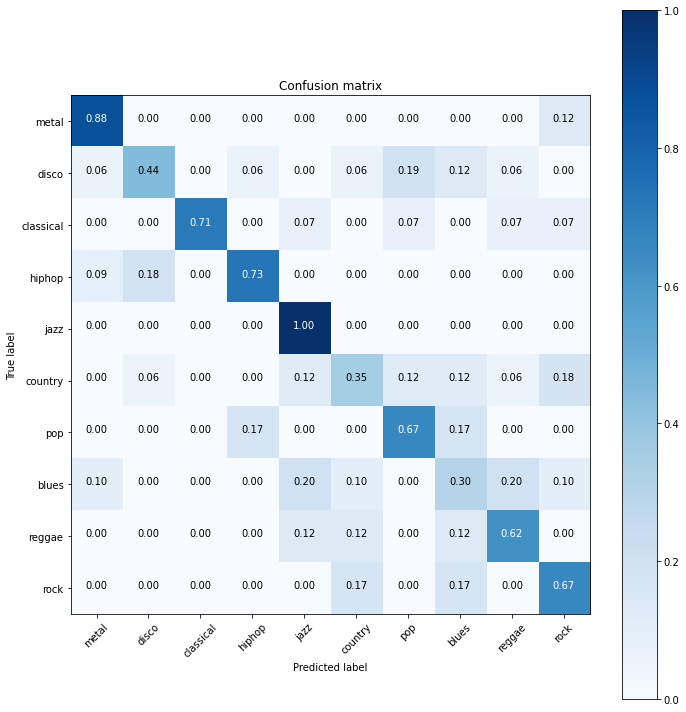

In [44]:
# plot confuison matrix
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

In [45]:
# majority voting
preds = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

scores_songs = np.split(np.argmax(preds, axis=1), 300)
scores_songs = [majority_vote(scores) for scores in scores_songs]

label = np.split(np.argmax(y_test, axis=1), 300)
label = [majority_vote(l) for l in label]

from sklearn.metrics import accuracy_score

print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))

ValueError: array split does not result in an equal division